# Bagging, Ensembling, Stacking
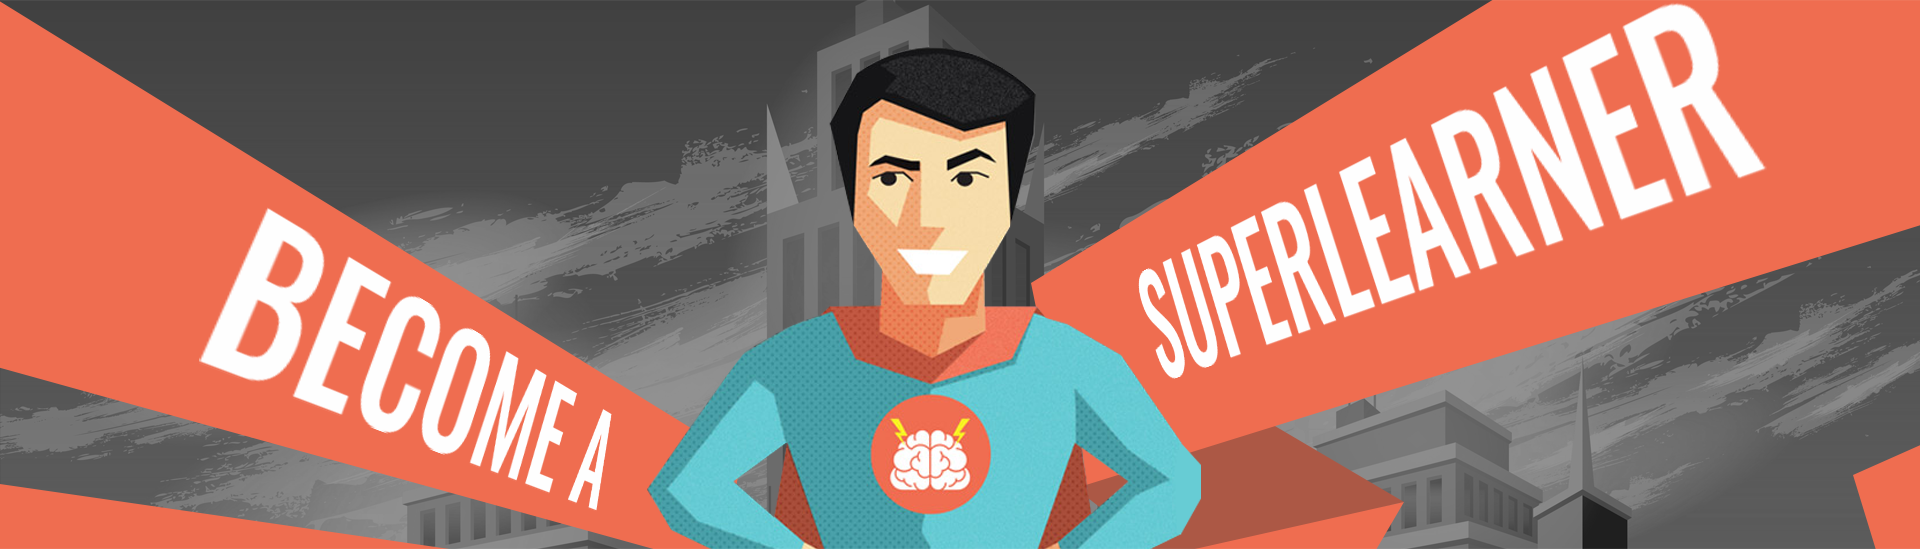
Image:  https://content.becomeasuperlearner.com/lp/superlearner-skillshare-v2/

# Setup

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

import catboost as cat
import lightgbm as lgb
import xgboost  as xgb

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mlens.ensemble import SuperLearner

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix

from category_encoders import OneHotEncoder

In [2]:
#!pip install mlens

# Data
* Kaggle 2015 Flight Delays (https://www.kaggle.com/usdot/flight-delays/downloads/flight-delays.zip/1)

In [3]:
flightDF  = pd.read_csv('./flight-delays/flights.csv')
airportDF = pd.read_csv('./flight-delays/airports.csv')
airlineDF = pd.read_csv('./flight-delays/airlines.csv')

/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
flightDF.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

In [5]:
flightDF.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
airportDF.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [7]:
airlineDF.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


# Processing
* Trim down the dataset for this example notebook
* We're emphasizing and looking at boosting rather than trying to optimize the accuracy rate
* Three simplifications
 * Trim features
 * Drop missing
 * Downsample to equal classes and smaller size

In [8]:
df = flightDF.copy()

## JFK Departures

In [9]:
df = df[df.ORIGIN_AIRPORT == 'JFK']
df.shape

(93811, 31)

## Features

In [10]:
keepCols = ['MONTH',
            'DAY_OF_WEEK',
            'AIRLINE',
            'DESTINATION_AIRPORT',
            'SCHEDULED_DEPARTURE',
            'SCHEDULED_ARRIVAL',
            'SCHEDULED_TIME',
            'DISTANCE',
            'ARRIVAL_DELAY',
            'CANCELLED'
]
df = df[keepCols].copy()

## Missing Data
* We have a small amount of missing arrival delays
* Rather than impute them to mean / median we'll drop them for simplicity

In [11]:
missingDF = pd.DataFrame(df.isna().mean().round(4) * 100)
missingDF.reset_index().rename(columns={'index': 'Feature', 0: 'Percent Missing'})

,Feature,Percent Missing
0,MONTH,0.00
1,DAY_OF_WEEK,0.00
2,AIRLINE,0.00
3,DESTINATION_AIRPORT,0.00
4,SCHEDULED_DEPARTURE,0.00
5,SCHEDULED_ARRIVAL,0.00
6,SCHEDULED_TIME,0.00
7,DISTANCE,0.00
8,ARRIVAL_DELAY,2.29
9,CANCELLED,0.00


In [12]:
df = df.dropna()

## Classification

In [13]:
## Balance Classes
delay  = df[df.ARRIVAL_DELAY > 0].sample(15000)
ontime = df[df.ARRIVAL_DELAY <= 0].sample(15000)
df = pd.concat([delay, ontime])

In [14]:
df['CLASS'] = np.where(df.ARRIVAL_DELAY <= 0, 'ONTIME', 'DELAY')

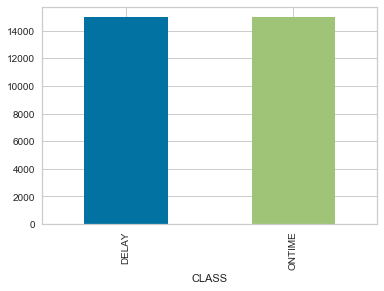

In [15]:
df.groupby('CLASS').size().plot.bar()

# EDA

## Top Arrival Airports & Airlines

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text yticklabel objects>)

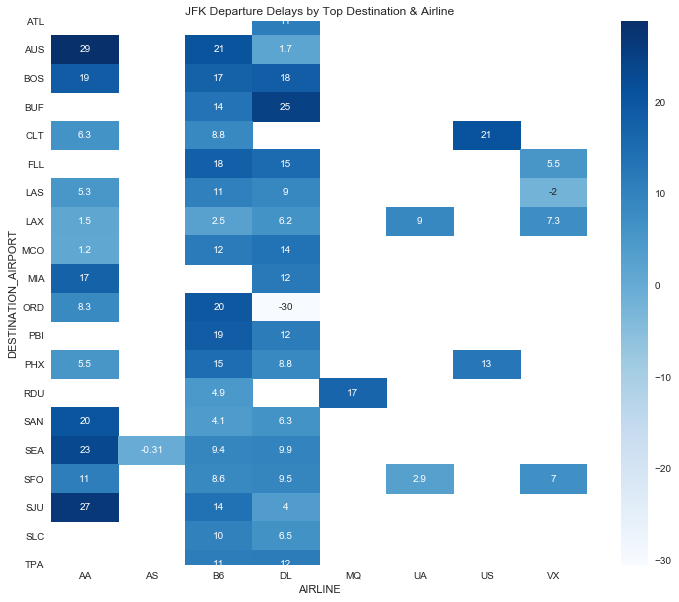

In [49]:
top = 20
topAirports = df.groupby('DESTINATION_AIRPORT').size() \
    .sort_values(ascending=False) \
    .head(top) \
    .index \
    .tolist()

pvt = df[df.DESTINATION_AIRPORT.isin(topAirports)] \
    .groupby(['AIRLINE', 'DESTINATION_AIRPORT']) \
    .agg({'ARRIVAL_DELAY': 'mean'}) \
    .reset_index() \
    .pivot(index='DESTINATION_AIRPORT', columns='AIRLINE', values='ARRIVAL_DELAY')

plt.figure(figsize=(12,10))
plt.title('JFK Departure Delays by Top Destination & Airline')
sns.heatmap(pvt, cmap='Blues', annot=True)
plt.yticks(rotation=0) 

## Airline Delay Distribution

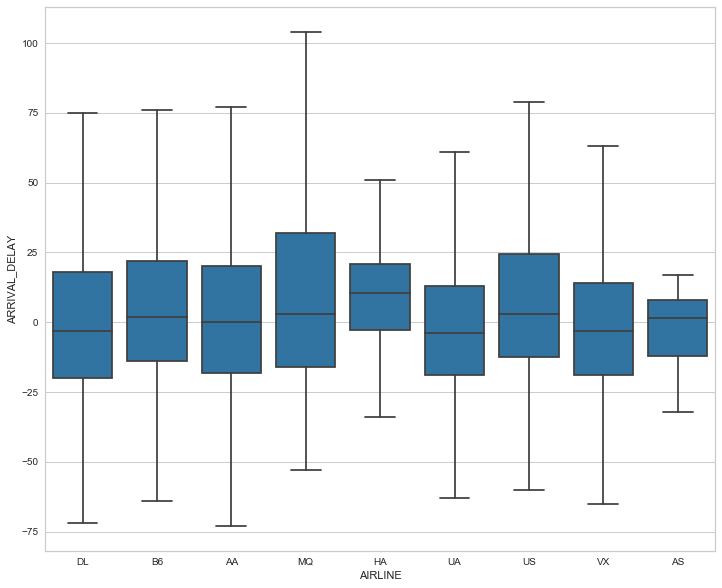

In [17]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.AIRLINE, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            color='#1f77b4')

## Delays by Month

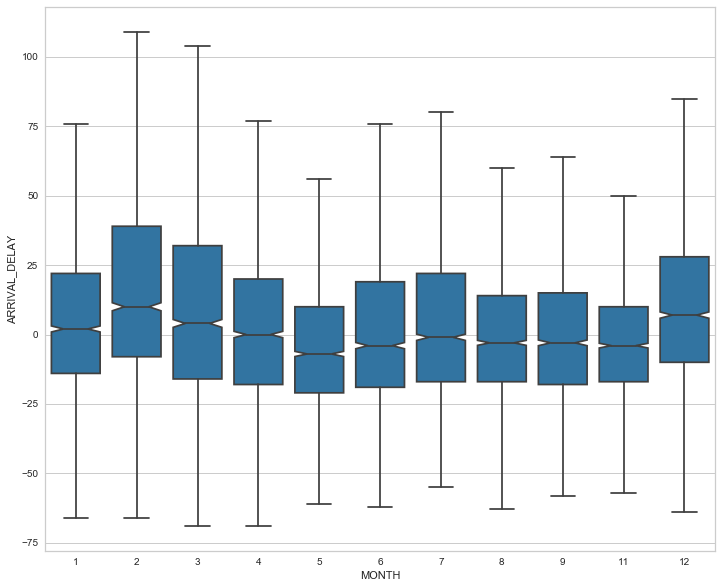

In [18]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.MONTH, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            notch=True,
            color='#1f77b4')

## Delays by Day of Week

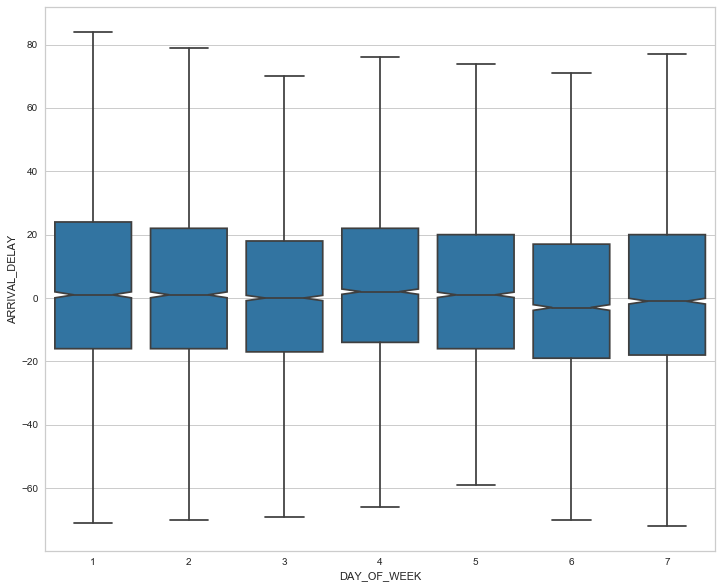

In [19]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.DAY_OF_WEEK, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            notch=True,
            color='#1f77b4')

## Distance

<Figure size 1080x864 with 0 Axes>

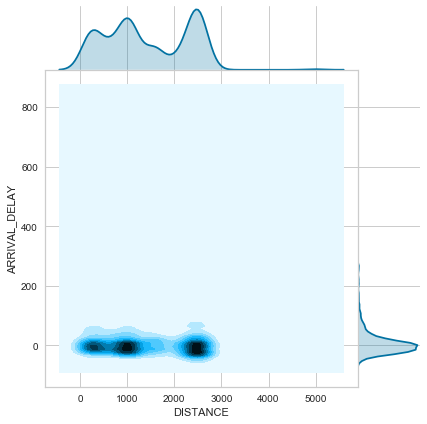

In [20]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot('DISTANCE', 'ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

## Scheduled Departure

<Figure size 1080x864 with 0 Axes>

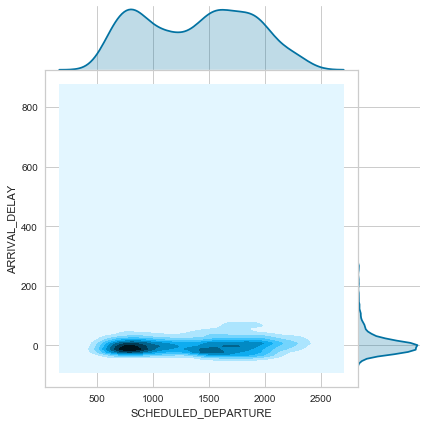

In [21]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot('SCHEDULED_DEPARTURE', 'ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

## Scheduled Arrival

<Figure size 1080x864 with 0 Axes>

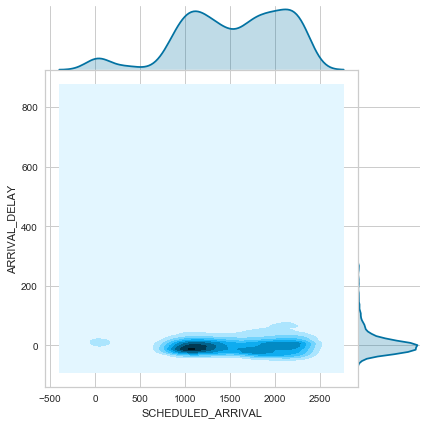

In [22]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot('SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

## Scheduled Time

<Figure size 1080x864 with 0 Axes>

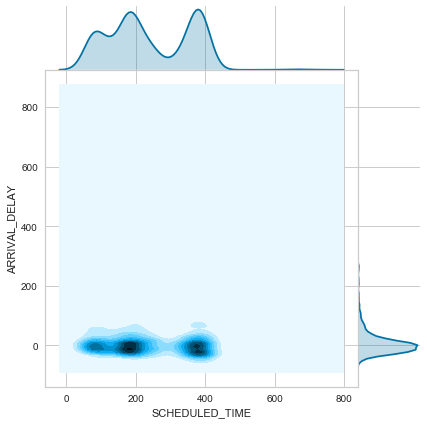

In [23]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot('SCHEDULED_TIME', 'ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

# Pipeline

In [24]:
df.dtypes

MONTH                    int64
DAY_OF_WEEK              int64
AIRLINE                 object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_ARRIVAL        int64
SCHEDULED_TIME         float64
DISTANCE                 int64
ARRIVAL_DELAY          float64
CANCELLED                int64
CLASS                   object
dtype: object

In [25]:
X = df.copy()
X = X.sample(frac=0.25, random_state=23)
X.MONTH       = X.MONTH.astype(str)
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype(str)
X.AIRLINE     = X.AIRLINE.astype(str)
X.DESTINATION_AIRPORT = X.DESTINATION_AIRPORT.astype(str)
print(X.dtypes)

y = X.CLASS
X = X.drop(['CLASS', 'CANCELLED', 'ARRIVAL_DELAY'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.where(y_train == 'ONTIME', 0, 1)
y_test  = np.where(y_test  == 'ONTIME', 0, 1)

MONTH                   object
DAY_OF_WEEK             object
AIRLINE                 object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_ARRIVAL        int64
SCHEDULED_TIME         float64
DISTANCE                 int64
ARRIVAL_DELAY          float64
CANCELLED                int64
CLASS                   object
dtype: object


In [26]:
ohe = OneHotEncoder(use_cat_names=True)
X_train_df = ohe.fit_transform(X_train)
X_test_df  = ohe.transform(X_test)

# Metrics

In [27]:
def measureErrors(y, y_hat):
    accuracy = accuracy_score(y, y_hat)
    print('Accuracy', accuracy)
    print('Confusion Matrix')
    print(confusion_matrix(y, y_hat))
    print('Classification Report')
    print(classification_report(y_hat, y))
    return accuracy

In [28]:
resultsDF = pd.DataFrame(columns=['Accuracy'])

# Bagging
* Idea - Reduce variance by bagging classifier by subsampling features and data and majority vote

In [29]:
rf = RandomForestClassifier(n_estimators=10)
et = ExtraTreesClassifier(n_estimators=10)
knn = KNeighborsClassifier(n_neighbors=20)
svc = SVC(gamma='auto')
rg = RidgeClassifier()

classifiers = [rf, et, knn, rg, svc]

In [30]:
baggingDF = pd.DataFrame(columns=['Baseline Mean', 'Bagging Mean', 'Baseline Std', 'Bagging Std'])
np.random.seed(1337)
for clf in classifiers:
    print('Running {}'.format(clf.__class__.__name__))
    bags     = BaggingClassifier(clf, max_samples=0.4, max_features=.9, random_state=25)
    bagging  = cross_val_score(bags, X_train_df, y_train, cv=5, n_jobs=-1)
    baseline = cross_val_score(clf, X_train_df, y_train, cv=5, n_jobs=-1)
    baggingDF.loc[clf.__class__.__name__] = [baseline.mean(), bagging.mean(), baseline.std(), bagging.std()]
    
    print('Baseline : Mean {:.3f} Std {:.3f}'.format(baseline.mean(), baseline.std()))
    print('Bagging  : Mean {:.3f} Std {:.3f}\n'.format(bagging.mean(), bagging.std()))
    
    resultsDF.loc[clf.__class__.__name__] = [baseline.mean()]
    resultsDF.loc['Bagging-' + clf.__class__.__name__] = [bagging.mean()]

Running RandomForestClassifier
Baseline : Mean 0.561 Std 0.011
Bagging  : Mean 0.585 Std 0.012

Running ExtraTreesClassifier
Baseline : Mean 0.557 Std 0.006
Bagging  : Mean 0.578 Std 0.012

Running KNeighborsClassifier
Baseline : Mean 0.550 Std 0.011
Bagging  : Mean 0.561 Std 0.015

Running RidgeClassifier
Baseline : Mean 0.578 Std 0.020
Bagging  : Mean 0.582 Std 0.019

Running SVC
Baseline : Mean 0.537 Std 0.008
Bagging  : Mean 0.545 Std 0.012



## Baseline

In [31]:
baggingDF[['Baseline Mean', 'Baseline Std']].sort_values('Baseline Mean', ascending=False)

,Baseline Mean,Baseline Std
RidgeClassifier,0.577829,0.020311
RandomForestClassifier,0.560668,0.010656
ExtraTreesClassifier,0.556665,0.006282
KNeighborsClassifier,0.550498,0.010928
SVC,0.536996,0.008085


## Bagging

In [32]:
baggingDF['Difference Mean'] = baggingDF['Bagging Mean'] - baggingDF['Baseline Mean']
baggingDF['Difference Std']  = baggingDF['Bagging Std']  - baggingDF['Baseline Std']
baggingDF[['Bagging Mean', 'Bagging Std', 'Difference Mean', 'Difference Std']] \
    .sort_values('Bagging Mean', ascending=False)

,Bagging Mean,Bagging Std,Difference Mean,Difference Std
RandomForestClassifier,0.585168,0.011894,0.024501,0.001238
RidgeClassifier,0.581666,0.018889,0.003837,-0.001422
ExtraTreesClassifier,0.578165,0.011822,0.021500,0.005539
KNeighborsClassifier,0.561161,0.014873,0.010663,0.003946
SVC,0.544993,0.011707,0.007998,0.003623


# Pasting
* Take small chunks of the data
* Grow predictor on chunk
* Paste predictors together
* Differs from Bagging
  * Bagging Sample with Replacement
  * Pasting Sample without Replacement
* Useful when you data has no practical way to fit into memory
* See Brieman (https://link.springer.com/article/10.1023/A:1007563306331)

# Voting
* Idea - Combine different types of classifiers
* Hard voting = One vote per classifier 
* Soft voting = Vote is argmax of class with largest mean softmax (probability)
 * All classifiers must have predict_proba
 * In our example, RidgeClassifer does not 

In [34]:
votingDF = pd.DataFrame(columns=['Voting Mean', 'Voting Std'])
np.random.seed(25)
classifiers = [knn, svc, rg, rf, et] 
vclf = VotingClassifier(estimators=[('KNN', knn),
                                    ('SVC', svc),
                                    ('Ridge', rg),
                                    ('RF', rf),
                                    ('ET', et)], voting='hard')
for clf, label in zip([rf, et, knn, rg, svc, vclf],
                      ['RF', 'ET', 'KNN', 'Ridge', 'SVC', 'Ensemble']):
    scores = cross_val_score(clf, X_train_df, y_train, cv=5, scoring='accuracy')
    print('Accuracy: %0.3f (+/- %0.3f) [%s]' % (scores.mean(), scores.std(), label))
    votingDF.loc[label] = [scores.mean(), scores.std()]
    
    if label == 'Ensemble':
        resultsDF.loc['Voting-Ensemble' + clf.__class__.__name__] = [scores.mean()]
votingDF

Accuracy: 0.565 (+/- 0.016) [RF]
Accuracy: 0.559 (+/- 0.014) [ET]
Accuracy: 0.550 (+/- 0.011) [KNN]
Accuracy: 0.578 (+/- 0.020) [Ridge]
Accuracy: 0.537 (+/- 0.008) [SVC]
Accuracy: 0.567 (+/- 0.014) [Ensemble]


,Voting Mean,Voting Std
RF,0.565329,0.015552
ET,0.558834,0.014156
KNN,0.550498,0.010928
Ridge,0.577829,0.020311
SVC,0.536996,0.008085
Ensemble,0.567004,0.014029


# Stacking
* Add layers of classifiers
* Multiple layers are processed sequentially
* A meta layer sits on top of the ensemble & learns the best output
* Typically, a linear model is used for meta
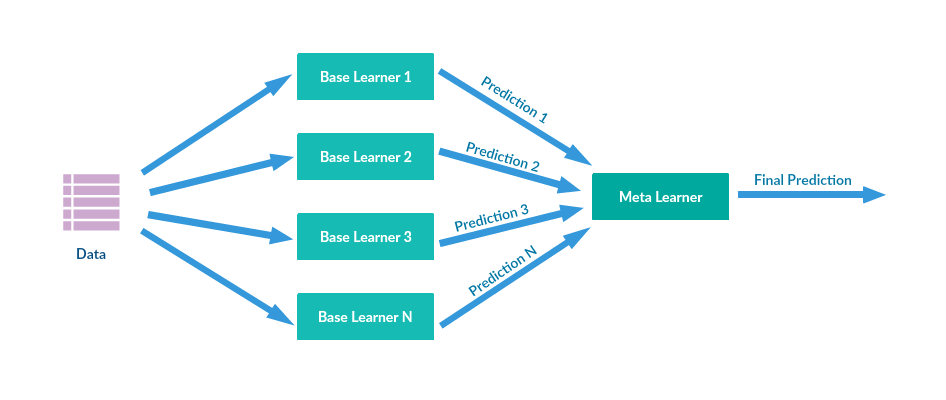
Image: https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de

## Super Learner Algorithm
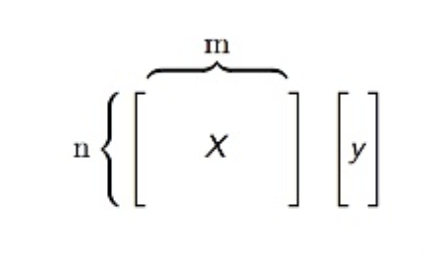

* Given input matrix X (n cases, m features) and outcomes Y
* Take L base learners
* Specify meta learner
* K-Fold CV on each base learner

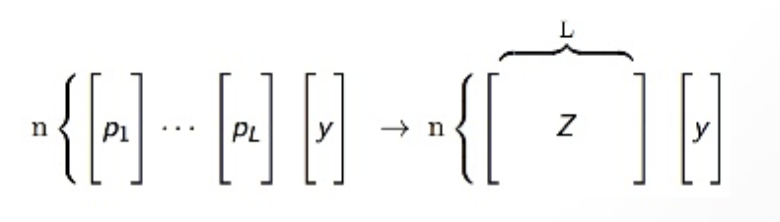

* Build new matric Z from base learners
* Train meta learner on Z and y

Images: https://www.slideshare.net/0xdata/strata-san-jose-2016-scalable-ensemble-learning-with-h2o

In [35]:
stackDF = pd.DataFrame(columns=['Accuracy'])

lr = LogisticRegression(solver='lbfgs')

clfs = [
    ('KNN', knn),
    ('SVC', svc),
    ('Ridge', rg),
    ('RF', rf),
    ('ET', et)
]

best = [0.00, '']
name = ''
for level in range(2, 6):
    for group in combinations(clfs, level):
        ensemble = SuperLearner(scorer = accuracy_score, random_state = 1337, folds = 5)

        names       = []
        classifiers = []
        
        for clf in group:
            names.append(clf[0])
            classifiers.append(clf[1])
            
        name = '-'.join(names)   

        ensemble.add(classifiers) # <-- Note! You can pass in pipelines per classifier
        ensemble.add_meta(lr)
        ensemble.fit(X_train_df, y_train)
        preds = ensemble.predict(X_test_df)
        accuracy = accuracy_score(preds, y_test)

        if accuracy > best[0]:
            best[0] = accuracy
            best[1] = name

        stackDF.loc[name] = [accuracy]
        resultsDF.loc['Stacking-' + name] = [accuracy]
        print('Training: ', name)

Training:  KNN-SVC
Training:  KNN-Ridge
Training:  KNN-RF
Training:  KNN-ET
Training:  SVC-Ridge
Training:  SVC-RF
Training:  SVC-ET
Training:  Ridge-RF
Training:  Ridge-ET
Training:  RF-ET
Training:  KNN-SVC-Ridge
Training:  KNN-SVC-RF
Training:  KNN-SVC-ET
Training:  KNN-Ridge-RF
Training:  KNN-Ridge-ET
Training:  KNN-RF-ET
Training:  SVC-Ridge-RF
Training:  SVC-Ridge-ET
Training:  SVC-RF-ET
Training:  Ridge-RF-ET
Training:  KNN-SVC-Ridge-RF
Training:  KNN-SVC-Ridge-ET
Training:  KNN-SVC-RF-ET
Training:  KNN-Ridge-RF-ET
Training:  SVC-Ridge-RF-ET
Training:  KNN-SVC-Ridge-RF-ET


In [36]:
stackDF.sort_values('Accuracy', ascending=False)

,Accuracy
Ridge-RF-ET,0.594000
SVC-Ridge-RF,0.586000
SVC-Ridge-RF-ET,0.586000
SVC-Ridge,0.586000
Ridge-RF,0.586000
Ridge-ET,0.586000
KNN-SVC-Ridge,0.586000
SVC-Ridge-ET,0.586000
KNN-Ridge,0.586000
KNN-SVC-RF,0.583333


# Stacking + Feature Propagation
* Stacking layers usually reduces variance
* Base learners get better at predicting output
* Residual errors get harder to correct from multicollinearity
* We can reduce variance if we pass original features to meta learner
 * We can use features in base and pass to meta
 * We can pass features untouched by base

# Ensemble Comparison

In [37]:
resultsDF.sort_values('Accuracy', ascending=False)

,Accuracy
Stacking-Ridge-RF-ET,0.594000
Stacking-Ridge-ET,0.586000
Stacking-KNN-SVC-Ridge,0.586000
Stacking-SVC-Ridge,0.586000
Stacking-KNN-Ridge,0.586000
Stacking-SVC-Ridge-RF,0.586000
Stacking-SVC-Ridge-ET,0.586000
Stacking-Ridge-RF,0.586000
Stacking-SVC-Ridge-RF-ET,0.586000
Bagging-RandomForestClassifier,0.585168


In [81]:
print('Improvement over Ridge {:.3f}%'.format((0.594000 - 0.577829) * 100.0 / 0.577829))
print('Improvement over RF    {:.3f}%'.format((0.594000 - 0.560668) * 100.0 / 0.560668))

Improvement over Ridge 2.799%
Improvement over RF    5.945%


# Homesite Competition
* Winner used stacking & ensembling to a 1st place finish
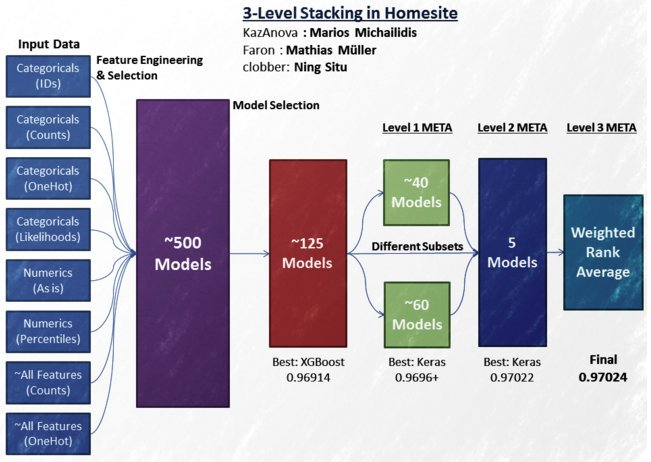

# Tips
* You typically won't get extremely large gains from ensembling
* Can be helpful in reducing variance
* Performs best when you have learners that are not highly correlated
* Not hard to implement mlens is a helpful library